In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
!pip install torchsummary
from torchsummary import summary
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


sns.set(style='darkgrid', font_scale=1.2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
!wget -c https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small

--2023-12-19 09:30:31--  https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'faces-dataset-small'

faces-dataset-small     [ <=>                ]   9.19K  --.-KB/s    in 0.03s   

2023-12-19 09:30:31 (263 KB/s) - 'faces-dataset-small' saved [9407]



In [5]:
!ls

faces-dataset-small


## Часть 1. Подготовка данных

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть.

In [6]:
data = '/kaggle/input/faces-dataset-small'

In [7]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and width of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        ])
    dataset = ImageFolder(root= data, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader


In [8]:
image_size = 128
batch_size = 128

In [9]:
train_dl = get_dataloader(image_size, batch_size)

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

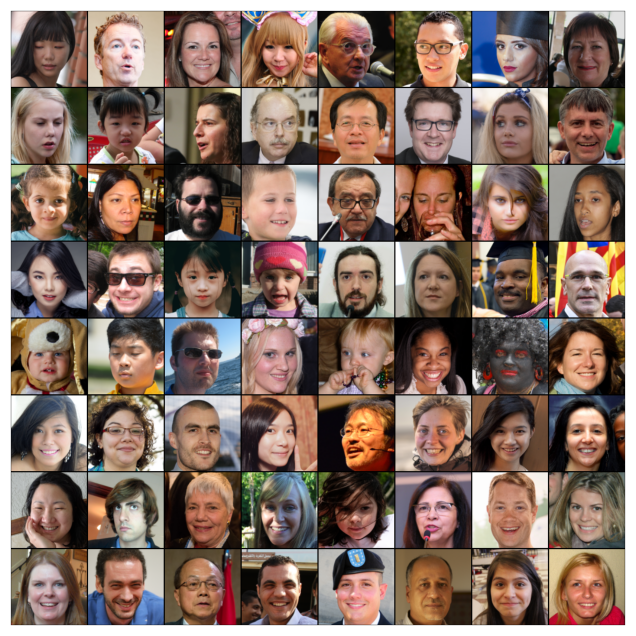

In [11]:
show_batch(train_dl)

## Часть 2. Построение и обучение модели

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [12]:
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # in: 3 x 128 x 128

            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # out: 64 x 64 x 64
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),    # out: 128 x 16 x 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # out: 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),  # out: 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(512, 1, kernel_size=8, stride=2, padding=0, bias=False),    # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [13]:
discriminator = Discriminator(image_size=128)

In [18]:
summary(discriminator,(3,128,128))

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1           [-1, 64, 64, 64]           3,072

         LeakyReLU-2           [-1, 64, 64, 64]               0

            Conv2d-3          [-1, 128, 32, 32]         131,072

       BatchNorm2d-4          [-1, 128, 32, 32]             256

         LeakyReLU-5          [-1, 128, 32, 32]               0

            Conv2d-6          [-1, 256, 16, 16]         524,288

       BatchNorm2d-7          [-1, 256, 16, 16]             512

         LeakyReLU-8          [-1, 256, 16, 16]               0

            Conv2d-9            [-1, 512, 8, 8]       2,097,152

      BatchNorm2d-10            [-1, 512, 8, 8]           1,024

        LeakyReLU-11            [-1, 512, 8, 8]               0

           Conv2d-12              [-1, 1, 1, 1]          32,768

          Flatten-13                    [-1, 1]               0

          Sigmoid-14   

In [14]:
latent_size = 128
class Generator(nn.Module):
    def __init__(self, latent_size, image_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(

            nn.ConvTranspose2d(latent_size, 512, kernel_size=8, stride=2, padding=0, bias=False), # out: 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), # out: 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # out: 64 x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),   # out: 32 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),      # out: 3 x 128 x 128
            nn.Tanh()

        )

    def forward(self, x):
        return self.model(x)

In [15]:
generator = Generator(latent_size, image_size=128)

torch.Size([128, 3, 128, 128])


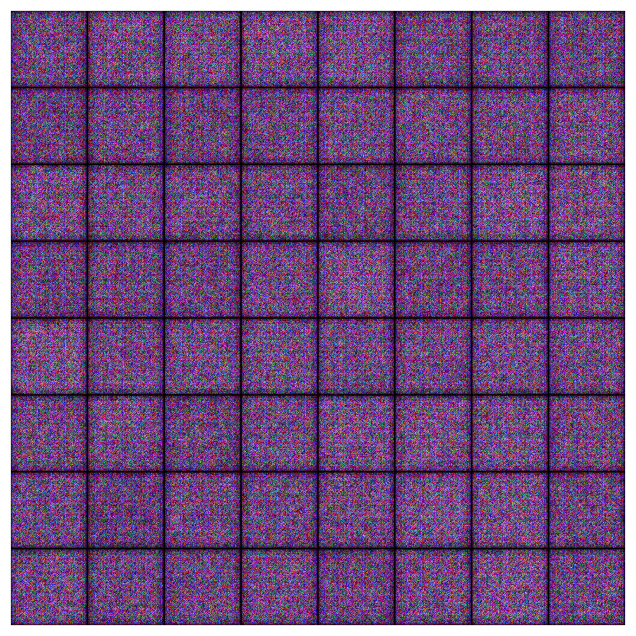

In [16]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [22]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [23]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image((fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            real_images = real_images.to(device)
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [26]:
history = fit(model, criterion, epochs = 30, lr = 0.0003)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 13.8878, loss_d: 0.4945, real_score: 0.8837, fake_score: 0.1111


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 6.9072, loss_d: 1.4793, real_score: 0.7761, fake_score: 0.2384


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 4.1000, loss_d: 0.8094, real_score: 0.7623, fake_score: 0.2253


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 4.5665, loss_d: 0.3837, real_score: 0.8459, fake_score: 0.1384


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 3.8240, loss_d: 1.3148, real_score: 0.7133, fake_score: 0.2926


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 3.1558, loss_d: 0.8447, real_score: 0.7441, fake_score: 0.2501


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 3.6769, loss_d: 0.9060, real_score: 0.7510, fake_score: 0.2566


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 4.0791, loss_d: 0.8739, real_score: 0.7561, fake_score: 0.2704


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 3.3604, loss_d: 1.0681, real_score: 0.7022, fake_score: 0.2852


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 3.2959, loss_d: 0.9130, real_score: 0.7246, fake_score: 0.2633


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 3.4098, loss_d: 0.9214, real_score: 0.7397, fake_score: 0.2655


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 3.5512, loss_d: 0.8513, real_score: 0.7480, fake_score: 0.2499


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 3.7456, loss_d: 0.7980, real_score: 0.7471, fake_score: 0.2440


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 3.6264, loss_d: 1.0643, real_score: 0.7226, fake_score: 0.2649


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 3.2394, loss_d: 0.8550, real_score: 0.7429, fake_score: 0.2435


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 3.1433, loss_d: 0.8427, real_score: 0.7631, fake_score: 0.2519


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 3.2151, loss_d: 0.7123, real_score: 0.7723, fake_score: 0.2152


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 3.4029, loss_d: 0.7370, real_score: 0.7738, fake_score: 0.2375


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 3.5403, loss_d: 0.8627, real_score: 0.7529, fake_score: 0.2471


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 3.8079, loss_d: 0.8704, real_score: 0.7461, fake_score: 0.2527


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 3.5753, loss_d: 0.8312, real_score: 0.7392, fake_score: 0.2322


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 3.7337, loss_d: 0.6509, real_score: 0.7960, fake_score: 0.2271


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 4.2374, loss_d: 0.9119, real_score: 0.7595, fake_score: 0.2138


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 3.1729, loss_d: 0.7788, real_score: 0.7640, fake_score: 0.2523


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 3.4872, loss_d: 0.5664, real_score: 0.8095, fake_score: 0.1848


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 3.9501, loss_d: 0.9311, real_score: 0.7842, fake_score: 0.2171


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 3.4895, loss_d: 0.7371, real_score: 0.7712, fake_score: 0.2246


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 3.4533, loss_d: 0.3820, real_score: 0.8425, fake_score: 0.1524


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 4.0042, loss_d: 0.8183, real_score: 0.7840, fake_score: 0.2133


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 3.7256, loss_d: 0.6740, real_score: 0.7803, fake_score: 0.2160
Saving generated-images-0030.png


In [37]:
losses_g, losses_d, real_scores, fake_scores = history

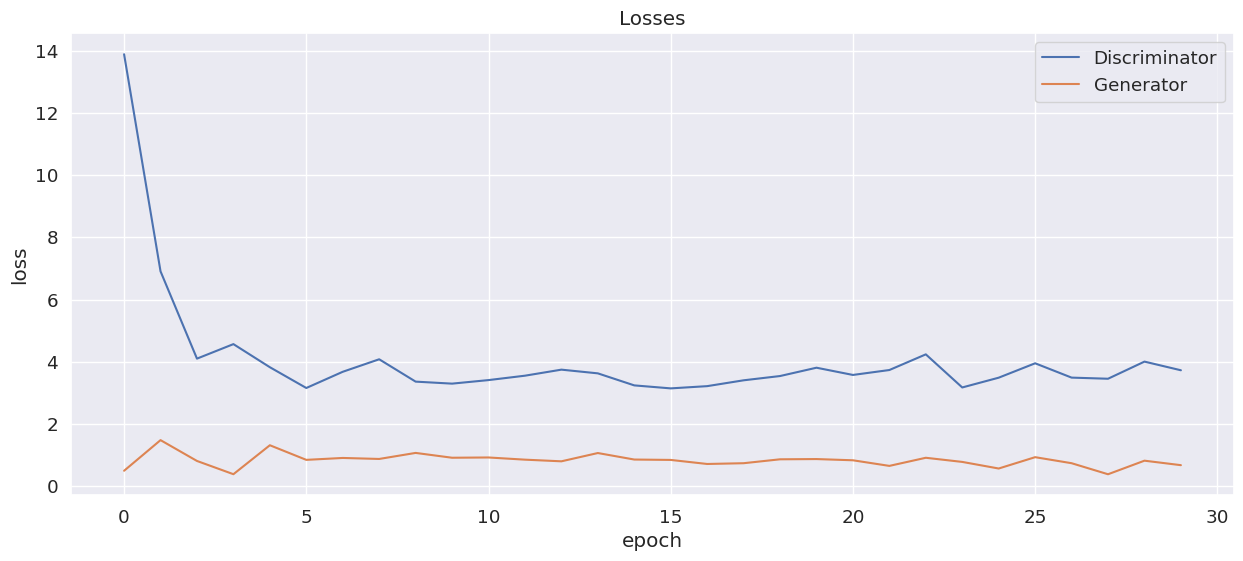

In [28]:
plt.figure(figsize=(15, 6))
plt.plot(losses_g, '-')
plt.plot(losses_d, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишем функцию, которая выводит изображения, сгенерированные нашим генератором

In [29]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [30]:
generated_img = cv2.imread(f'./generated/generated-images-0030.png')
generated_img = generated_img[:, :, [2, 1, 0]]

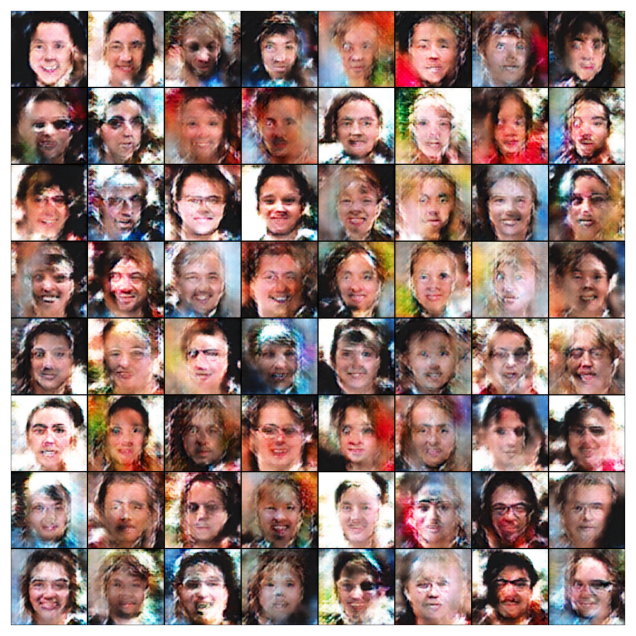

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

In [32]:
def show_images(generated):
    plt.figure(figsize=(16, 8))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(generated[i].cpu().numpy().transpose((1, 2, 0)))
        plt.axis("off")
    plt.show()

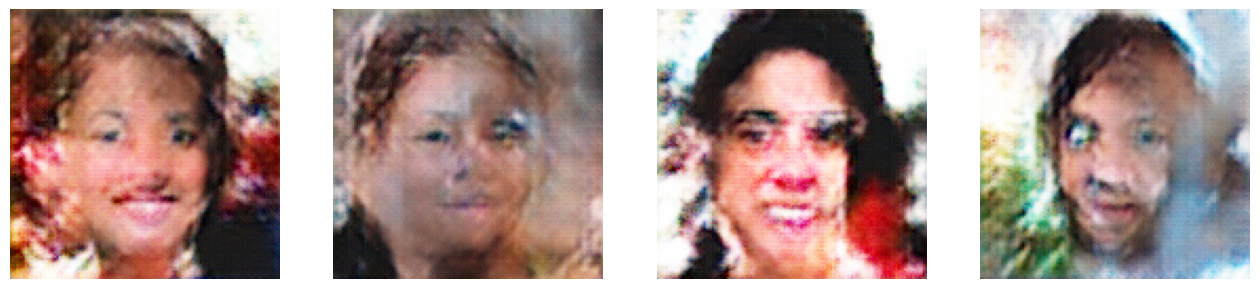

In [33]:
show_images(fake_images.detach())

## Часть 4. Leave-one-out-1-NN classifier accuracy

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [34]:
num = 1000
model["generator"].eval()

fixed_latent = torch.randn(num, latent_size, 1, 1, device=device)
fake_images = model["generator"].to(device)(fixed_latent)
real_images = next(iter(get_dataloader(image_size, batch_size)))[0]

In [35]:
zeros = torch.zeros(num, 1, device='cpu')
ones = torch.ones(num, 1, device='cpu')

X = torch.cat((fake_images.cpu().view(fake_images.size(0), -1), real_images.cpu().view(real_images.size(0), -1)), 0).detach().numpy()
y = torch.cat((zeros, ones)).detach().numpy()

KNN = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

score_hist = []
predictions = []
target = []

for train_inx, test_inx in tqdm(loo.split(X)):
    X_train, X_test = X[train_inx], X[test_inx]
    y_train, y_test = y[train_inx], y[test_inx]
    
    KNN.fit(X_train, np.ravel(y_train))
    pred = KNN.predict(X_test)
    score_hist.append(accuracy_score(pred, y_test))
    predictions.append(pred)
    target.append(y_test)

0it [00:00, ?it/s]

In [38]:
print(np.mean(score_hist))

0.8936170212765957
